In [1]:
import numpy as np
import pandas as pd
import artm
import matplotlib.pyplot as plt
import gc
import os
import pymorphy2
import re
from model import TopicModel

### Global parameters

In [2]:
FULL_PROCESSING = True
SAVE_PROCESSING_DATA = True
DATASET_PATH = '../../../../data/datasets/Russia.csv'
PROCESSED_DATASET_PATH = 'processed_data/data_russia_processed.csv'

### Load and prepare data for model

In [3]:
%%time
tm = TopicModel()

CPU times: user 64 ms, sys: 8 ms, total: 72 ms
Wall time: 76.5 ms


In [4]:
if FULL_PROCESSING:
    data = tm.load_data(DATASET_PATH)

    date = tm.get_date(data, column='url')
    data['year'] = date.dt.year
    data['month'] = date.dt.month

    data['docID'] = tm.get_docid(data)
    data['lemmatized_text'] = tm.tokenize_normalize(data['text'])

    if SAVE_PROCESSING_DATA:
        tm.save_data(data, PROCESSED_DATASET_PATH)
else:
    data = tm.load_data(PROCESSED_DATASET_PATH, convert_processed_text=True)

[2019-01-25 11:37:32,032] {model.py:39} INFO - Loading data from ../../../../data/datasets/Russia.csv ...
[2019-01-25 11:37:35,181] {model.py:73} INFO - Tokenize and normalize text...


In [5]:
DATASET_PATH

'../../../../data/datasets/Russia.csv'

In [6]:
id_date = tm.get_id_date(data)

In [7]:
%%time
tm.prepare_data_for_model(data=data, vwpath='processed_data/russia.vw', batches_path='processed_data/batches')

[2019-01-25 11:41:32,841] {model.py:98} INFO - Creating VW file processed_data/russia.vw ...
[2019-01-25 11:41:34,470] {model.py:106} INFO - Init BatchVectorizer for processed_data/batches ...
[2019-01-25 11:41:43,953] {model.py:118} INFO - Gather dictionary from processed_data/batches ...
CPU times: user 40.1 s, sys: 1.2 s, total: 41.3 s
Wall time: 16.2 s


In [8]:
# %%time
# tm.prepare_data_for_model(data=None, vwpath='processed_data/russia.vw', batches_path='processed_data/batches')

### Filter dictionary

In [36]:
tm.filter_dictionary(min_tf=5, max_df_rate=0.1)

In [37]:
tm.dictionary

artm.Dictionary(name=74ca435e-7595-46cf-a171-84c627215fb6, num_entries=49981)

### Init model

In [181]:
hier = artm.hARTM()

In [182]:
level0 = hier.add_level(num_topics=10)

## Level 0

In [183]:
tm.init_model(model_level=level0, model_name='hARTM')

[2019-01-28 05:01:29,842] {model.py:130} INFO - Initializing hARTM model


In [184]:
### Add scores

scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
kwarg_scores = {scorer: {'name': scorer} for scorer in scores}

tm.add_scores(**kwarg_scores)

[2019-01-28 05:01:30,209] {model.py:155} INFO - Scorer PerplexityScore is added to the model
[2019-01-28 05:01:30,210] {model.py:155} INFO - Scorer SparsityThetaScore is added to the model
[2019-01-28 05:01:30,211] {model.py:155} INFO - Scorer SparsityPhiScore is added to the model
[2019-01-28 05:01:30,212] {model.py:155} INFO - Scorer TopTokensScore is added to the model
[2019-01-28 05:01:30,213] {model.py:155} INFO - Scorer TopicKernelScore is added to the model


In [185]:
regularizers = {
    'DecorrelatorPhiRegularizer': {'tau': 1e5}
}

In [186]:
tm.add_regularizers(**regularizers)

[2019-01-28 05:01:30,249] {model.py:180} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}


### Fit model first 5 passes

In [187]:
tm.fit_model(num_collection_passes=5)

In [188]:
# tm.save_model(force=True)

In [189]:
tm.print_measures()

PerplexityScore:  486.032
SparsityThetaScore:  0.000
SparsityPhiScore:  0.002
TopTokensScore:  0.000
TopicKernelScore:  0.000


In [190]:
tm.model.score_tracker['SparsityPhiScore'].value

[0.0, 0.0, 0.0, 7.202736742328852e-05, 0.002186831086874008]

In [191]:
# tm.plot_perplexity()

In [192]:
for topic_name in level0.topic_names:
    print(topic_name + ': ')
    print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_name]))

topic_0: 
автомобиль мужчина мвд полиция улица машина происшествие взрыв обнаружить убийство
topic_1: 
акция митинг адвокат участник площадь прокуратура активист против аэропорт признать
topic_2: 
министр закон сумма бывший должность законопроект государственный министерство мэр срок
topic_3: 
процент партия выбор губернатор единый выборы кандидат избирательный федерация округа
topic_4: 
ходорковский михаил мэр деятельность здание школа лебедев русский руководитель развитие
topic_5: 
крым лидер украина закон общественный совет проект медведев дмитрий единый
topic_6: 
пожар мчс здание возгорание сша процент площадь пожарный огонь республика
topic_7: 
военный чечня государство гражданин сша оборона журналист республика международный американский
topic_8: 
ребёнок мчс летний погибший пожар женщина метр тело северный июнь
topic_9: 
авария дорога движение станция километр поезд пассажир нарушение участок строительство


In [193]:
len(set(it.chain(*level0.score_tracker['TopTokensScore'].last_tokens.values()))) / len(list(it.chain(*level0.score_tracker['TopTokensScore'].last_tokens.values())))

0.9

### Add regularizer for phi for 5 passes

In [194]:
regularizers = {
    'SmoothSparsePhiRegularizer': {'tau': -15},
}

In [195]:
tm.add_regularizers(**regularizers)

[2019-01-28 05:01:46,980] {model.py:180} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -15}


In [196]:
tm.fit_model(num_collection_passes=5)

In [197]:
# tm.save_model(force=True)

In [198]:
tm.print_measures()

PerplexityScore:  351.268
SparsityThetaScore:  0.001
SparsityPhiScore:  0.918
TopTokensScore:  0.000
TopicKernelScore:  0.000


### Add regularizer for theta for 5 passes

In [199]:
regularizers = {
    'SmoothSparseThetaRegularizer': {'tau': -15},
}

In [200]:
tm.add_regularizers(**regularizers)

[2019-01-28 05:02:03,483] {model.py:180} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -15}


In [201]:
tm.fit_model(num_collection_passes=5)

In [202]:
# tm.save_model(force=True)

In [203]:
tm.print_measures()

PerplexityScore:  186.995
SparsityThetaScore:  0.889
SparsityPhiScore:  0.927
TopTokensScore:  0.000
TopicKernelScore:  0.000


In [204]:
for topic_name in level0.topic_names:
    print(topic_name + ': ')
    print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_name]))

topic_0: 
мужчина летний автомобиль полиция мвд машина убийство водитель женщина взрыв
topic_1: 
акция митинг адвокат площадь ходорковский участник активист свобода движение лебедев
topic_2: 
закон законопроект компания процент средство миллиард гражданин чиновник сумма государственный
topic_3: 
партия процент выбор кандидат единый выборы избирательный губернатор пост лидер
topic_4: 
памятник церковь храм православный здание русский патриарх рпц музей религиозный
topic_5: 
крым образование совет государство вуз государственный украина медведев школа наш
topic_6: 
пожар здание мчс возгорание пожарный площадь взрыв метр огонь квадратный
topic_7: 
военный сша чечня украина сила государство республика министр оборона сторона
topic_8: 
ребёнок мчс вода тело обнаружить погибший судно край борт спасатель
topic_9: 
самолёт авария движение станция пассажир аэропорт поезд дорога транспорт километр


## Level 1

In [312]:
# hier.del_level(1)

In [226]:
# hier.num_levels

2

In [313]:
level1 = hier.add_level(num_topics=20, topic_names=['child_topic_' + str(i) for i in range(20)], 
                        parent_level_weight=10)

In [314]:
tm.init_model(model_level=level1, model_name='hARTM')

[2019-01-28 05:14:59,452] {model.py:130} INFO - Initializing hARTM model


In [315]:
scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
kwarg_scores = {scorer: {'name': scorer} for scorer in scores}

In [316]:
tm.add_scores(**kwarg_scores)

[2019-01-28 05:14:59,883] {model.py:155} INFO - Scorer PerplexityScore is added to the model
[2019-01-28 05:14:59,884] {model.py:155} INFO - Scorer SparsityThetaScore is added to the model
[2019-01-28 05:14:59,885] {model.py:155} INFO - Scorer SparsityPhiScore is added to the model
[2019-01-28 05:14:59,887] {model.py:155} INFO - Scorer TopTokensScore is added to the model
[2019-01-28 05:14:59,888] {model.py:155} INFO - Scorer TopicKernelScore is added to the model


In [317]:
regularizers = {
    'HierarchySparsingThetaRegularizer': {'tau': 100.0},
    'SmoothSparseThetaRegularizer': {'tau': -15},
    'SmoothSparsePhiRegularizer': {'tau': -15},
    'DecorrelatorPhiRegularizer': {'tau': 1e5}
}

In [318]:
tm.add_regularizers(**regularizers)

[2019-01-28 05:14:59,916] {model.py:180} INFO - Regularizer HierarchySparsingThetaRegularizer is added to the model with arguments:
{'tau': 100.0}
[2019-01-28 05:14:59,917] {model.py:180} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -15}
[2019-01-28 05:14:59,919] {model.py:180} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -15}
[2019-01-28 05:14:59,920] {model.py:180} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}


In [319]:
tm.fit_model(num_collection_passes=10)

In [320]:
tm.print_measures()

PerplexityScore:  399.025
SparsityThetaScore:  0.970
SparsityPhiScore:  0.937
TopTokensScore:  0.000
TopicKernelScore:  0.000


In [321]:
for topic_name in level0.topic_names:
    print(topic_name + ': ')
    print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_name]))

topic_0: 
мужчина летний автомобиль полиция мвд машина убийство водитель женщина взрыв
topic_1: 
акция митинг адвокат площадь ходорковский участник активист свобода движение лебедев
topic_2: 
закон законопроект компания процент средство миллиард гражданин чиновник сумма государственный
topic_3: 
партия процент выбор кандидат единый выборы избирательный губернатор пост лидер
topic_4: 
памятник церковь храм православный здание русский патриарх рпц музей религиозный
topic_5: 
крым образование совет государство вуз государственный украина медведев школа наш
topic_6: 
пожар здание мчс возгорание пожарный площадь взрыв метр огонь квадратный
topic_7: 
военный сша чечня украина сила государство республика министр оборона сторона
topic_8: 
ребёнок мчс вода тело обнаружить погибший судно край борт спасатель
topic_9: 
самолёт авария движение станция пассажир аэропорт поезд дорога транспорт километр


In [322]:
for topic_name in level1.topic_names:
    print(topic_name + ': ')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[topic_name]))

child_topic_0: 
сша военный украина чечня сила государство оборона министр американский войско
child_topic_1: 
чечня военный военнослужащий сторона дмитрий республика вооружённый спецслужба грозный кадыров
child_topic_2: 
пожар здание мчс возгорание пожарный площадь взрыв метр огонь квадратный
child_topic_3: 
самолёт станция движение поезд авария пассажир аэропорт дорога участок компания
child_topic_4: 
процент партия губернатор пост бывший единый образ заседание отказаться четыре
child_topic_5: 
закон законопроект чиновник компания процент гражданин срок размер прокуратура проверка
child_topic_6: 
партия губернатор выбор кпрф единый парламент процент пост заседание кандидат
child_topic_7: 
совет нарушение председатель мэр заседание общественный срок руководитель против единый
child_topic_8: 
наш иметь республика необходимый гражданин среда военный международный группа государство
child_topic_9: 
ребёнок мчс вода тело судно погибший обнаружить борт спасатель край
child_topic_10: 
совет

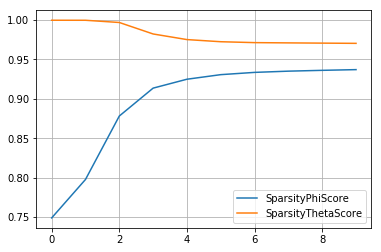

In [330]:
sparse_scores = {}
sparse_scores['SparsityPhiScore'] = tm.model.score_tracker['SparsityPhiScore'].value
sparse_scores['SparsityThetaScore'] = tm.model.score_tracker['SparsityThetaScore'].value
pd.DataFrame(sparse_scores).plot(grid=True)

## Evaluate hierarchy


### Support

Usually it is needed to set psi threshold that is min value of $p(t | a)$ so that link a-t will be included to topic graph. But with high threshold some topics will have no parents. We define support as maximum avialable threshold for Psi matrix with which all topics will have at least one ancestor.


In [331]:
psi = level1.get_psi()

In [332]:
print("Psi support:", psi.values.max(axis=1).min())

Psi support: 0.053318456


### Mean parents count

In BigARTM hierarchy is defined as multilevel topic graph rathjer than topic tree. So it is reasonable to evaluate mean count of parents.

In [333]:
psi_threshold = 0.01
parent_counts = np.zeros(0)
for level_idx in range(1, hier.num_levels):
    psi = hier.get_level(level_idx).get_psi().values
    parent_counts = np.hstack((parent_counts, (psi > psi_threshold).sum(axis=1)))
print("Mean parents count:", parent_counts.mean())

Mean parents count: 1.65


### Top tokens relations
We can construct parent-children relations with $p(parent|child)$ matrix, but psi matrix gives us only $p(child|parent)$. We can get $p(parent|child)$ this way:


In [326]:
batch = artm.messages.Batch()
batch_name = 'phi1.batch'

with open(batch_name, "rb") as f:
    batch.ParseFromString(f.read())
    
Ntw = np.zeros(len(level0.topic_names))
    
for i,item in enumerate(batch.item):
    for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
        Ntw[i] += token_weight

Nt1t0 = np.array(psi) * Ntw
psi_bayes = (Nt1t0 / Nt1t0.sum(axis=1)[:, np.newaxis]).T

In [327]:
indexes_child = np.argmax(psi_bayes, axis=0)

In [328]:
indexes_child

array([7, 7, 6, 9, 3, 2, 3, 1, 7, 8, 5, 4, 5, 1, 9, 2, 0, 0, 3, 4])

In [329]:
for topic_num in range(10):
    topic_parent_name = f'topic_{topic_num}'
    print(topic_parent_name + ':')
    print(" ".join(level0.score_tracker['TopTokensScore'].last_tokens[topic_parent_name]))
    print('')

    for child in np.where(indexes_child == topic_num)[0]:
        print('    ' + level1.topic_names[child] + ': ')
        print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[level1.topic_names[child]]))
        print('')
    print('-' * 80)

topic_0:
мужчина летний автомобиль полиция мвд машина убийство водитель женщина взрыв

    child_topic_16: 
двое летний ребёнок больница местный найти июнь женщина обнаружить апрель

    child_topic_17: 
мужчина автомобиль летний полиция мвд убийство машина водитель улица взрыв

--------------------------------------------------------------------------------
topic_1:
акция митинг адвокат площадь ходорковский участник активист свобода движение лебедев

    child_topic_7: 
совет нарушение председатель мэр заседание общественный срок руководитель против единый

    child_topic_13: 
акция митинг адвокат площадь ходорковский участник активист свобода движение лебедев

--------------------------------------------------------------------------------
topic_2:
закон законопроект компания процент средство миллиард гражданин чиновник сумма государственный

    child_topic_5: 
закон законопроект чиновник компания процент гражданин срок размер прокуратура проверка

    child_topic_15: 
закон госуда

## Level 2

In [362]:
level2 = hier.add_level(num_topics=40, topic_names=['child_topic_2_' + str(i) for i in range(40)], 
                        parent_level_weight=1)

In [363]:
tm.init_model(model_level=level2, model_name='hARTM')

[2019-01-28 10:31:50,212] {model.py:130} INFO - Initializing hARTM model


In [364]:
scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
kwarg_scores = {scorer: {'name': scorer} for scorer in scores}

In [365]:
tm.add_scores(**kwarg_scores)

[2019-01-28 10:31:50,729] {model.py:155} INFO - Scorer PerplexityScore is added to the model
[2019-01-28 10:31:50,730] {model.py:155} INFO - Scorer SparsityThetaScore is added to the model
[2019-01-28 10:31:50,731] {model.py:155} INFO - Scorer SparsityPhiScore is added to the model
[2019-01-28 10:31:50,732] {model.py:155} INFO - Scorer TopTokensScore is added to the model
[2019-01-28 10:31:50,733] {model.py:155} INFO - Scorer TopicKernelScore is added to the model


In [366]:
regularizers = {
    'HierarchySparsingThetaRegularizer': {'tau': 100.0},
    'SmoothSparseThetaRegularizer': {'tau': -15},
    'SmoothSparsePhiRegularizer': {'tau': -15},
    'DecorrelatorPhiRegularizer': {'tau': 1e5}
}

In [367]:
tm.add_regularizers(**regularizers)

[2019-01-28 10:31:50,763] {model.py:180} INFO - Regularizer HierarchySparsingThetaRegularizer is added to the model with arguments:
{'tau': 100.0}
[2019-01-28 10:31:50,764] {model.py:180} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -15}
[2019-01-28 10:31:50,765] {model.py:180} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -15}
[2019-01-28 10:31:50,767] {model.py:180} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}


In [368]:
tm.fit_model(num_collection_passes=10)

In [369]:
tm.print_measures()

PerplexityScore:  1046.470
SparsityThetaScore:  0.995
SparsityPhiScore:  0.961
TopTokensScore:  0.000
TopicKernelScore:  0.000


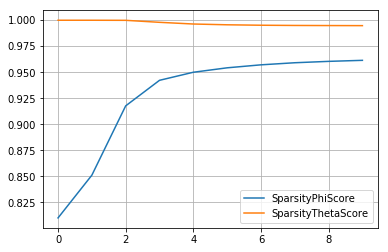

In [370]:
sparse_scores = {}
sparse_scores['SparsityPhiScore'] = tm.model.score_tracker['SparsityPhiScore'].value
sparse_scores['SparsityThetaScore'] = tm.model.score_tracker['SparsityThetaScore'].value
pd.DataFrame(sparse_scores).plot(grid=True)

In [371]:
psi = level2.get_psi()

In [372]:
print("Psi support:", psi.values.max(axis=1).min())

Psi support: 0.021810383


In [373]:
batch = artm.messages.Batch()
batch_name = 'phi2.batch'

with open(batch_name, "rb") as f:
    batch.ParseFromString(f.read())
    
Ntw = np.zeros(len(level1.topic_names))
    
for i,item in enumerate(batch.item):
    for (token_id, token_weight) in zip(item.field[0].token_id, item.field[0].token_weight):
        Ntw[i] += token_weight

Nt2t1 = np.array(psi) * Ntw
psi_bayes = (Nt2t1 / Nt2t1.sum(axis=1)[:, np.newaxis]).T

In [374]:
indexes_child = np.argmax(psi_bayes, axis=0)

In [375]:
indexes_child

array([15,  0, 15, 18, 11,  9,  9, 13, 15, 17,  4,  2,  7,  5, 16, 13, 16,
       14,  4, 11, 13, 17, 17,  5,  8, 16, 11, 17,  3,  3,  1, 17,  9, 12,
       18, 18, 10, 19, 10,  0])

In [376]:
for topic_num, topic_parent_name in enumerate(level1.topic_names):
    print(topic_parent_name + ':')
    print(" ".join(level1.score_tracker['TopTokensScore'].last_tokens[topic_parent_name]))
    print('')

    for child in np.where(indexes_child == topic_num)[0]:
        print('    ' + level2.topic_names[child] + ': ')
        print(" ".join(level2.score_tracker['TopTokensScore'].last_tokens[level2.topic_names[child]]))
        print('')
    print('-' * 80)

child_topic_0:
сша военный украина чечня сила государство оборона министр американский войско

    child_topic_2_1: 
сша украина военный государство оборона сила американский министр безопасность песок

    child_topic_2_39: 
военный чечня войско сирия международный кадыров армия вооружённый сила сша

--------------------------------------------------------------------------------
child_topic_1:
чечня военный военнослужащий сторона дмитрий республика вооружённый спецслужба грозный кадыров

    child_topic_2_30: 
военный военнослужащий дмитрий сторона республика чечня спецслужба грозный чеченский вооружённый

--------------------------------------------------------------------------------
child_topic_2:
пожар здание мчс возгорание пожарный площадь взрыв метр огонь квадратный

    child_topic_2_11: 
пожар здание мчс возгорание пожарный площадь метр взрыв огонь квадратный

--------------------------------------------------------------------------------
child_topic_3:
самолёт станция движе

### Load model

In [377]:
# tm.load_model()

### Metrics

In [378]:
phi = tm.model.get_phi()
phi['word'] = phi.index

for col in phi.columns[:10]:
    if col != 'word':
        print(col)
        print(phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20])

child_topic_2_0
[('@default_class', 'государственный') ('@default_class', 'средство')
 ('@default_class', 'миллиард') ('@default_class', 'ребёнок')
 ('@default_class', 'проект') ('@default_class', 'рынок')
 ('@default_class', 'штраф') ('@default_class', 'составить')
 ('@default_class', 'министр') ('@default_class', 'компания')
 ('@default_class', 'иметь') ('@default_class', 'городской')
 ('@default_class', 'услуга') ('@default_class', 'закон')
 ('@default_class', 'законопроект') ('@default_class', 'государство')
 ('@default_class', 'деньга') ('@default_class', 'изменение')
 ('@default_class', 'инициатива') ('@default_class', 'деятельность')]
child_topic_2_1
[('@default_class', 'сша') ('@default_class', 'украина')
 ('@default_class', 'военный') ('@default_class', 'государство')
 ('@default_class', 'оборона') ('@default_class', 'сила')
 ('@default_class', 'американский') ('@default_class', 'министр')
 ('@default_class', 'безопасность') ('@default_class', 'песок')
 ('@default_class', 'лид

### Get topics-docs matrix

In [379]:
gb = tm.get_time_topics(id_date, topics=level2.topic_names)

### PyGal

In [380]:
import pygal
from IPython.display import SVG, HTML

In [381]:
# Эта штука нужна только для того, чтобы в ноутбуке рисовалось
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [382]:
# line_chart = pygal.StackedLine(fill=True, show_dots=False)
# line_chart.title = 'Topics'
# for topic in topics:
#     line_chart.add(topic, gb[topic].values)

# HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [383]:
# # Так можно посмотреть большую картинку в отдельной вкладке
# line_chart.render_in_browser()

In [384]:
topics = tm.model.topic_names

In [385]:
from pygal.style import Style

# Если отображать долю, а не абсолютное значение, то становится более читаемо

s = gb[topics].sum(axis=1)
line_chart = pygal.StackedLine(fill=True, show_dots=False,
                               stroke_style={'width': 0.5},
                               style=Style(legend_font_size=6),
                              legend_at_bottom=True)
line_chart.title = 'Topics'
# line_chart.x_labels = map(str, range(2002, 2013))
for topic in topics:
    line_chart.add(topic, gb[topic].values/s)

HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))